In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

from PIL import Image

import glob
import os
import re

%matplotlib inline

In [2]:
cwd = os.getcwd()

SAMPLE_SIZE = 10890
TRAIN_SPLIT_RATIO = 0.7
VALIDATION_SPLIT_RATIO = 0.2

PADDING_SIZE = 20
IMAGE_SIZE = 256
BATCH_SIZE = 4

BLOCK_POS_RANGE = 10

In [3]:
index = np.arange(SAMPLE_SIZE) + 1
np.random.seed(1234)
np.random.shuffle(index)

split = (int) (SAMPLE_SIZE * TRAIN_SPLIT_RATIO)
split_val = (int) (SAMPLE_SIZE * (TRAIN_SPLIT_RATIO + VALIDATION_SPLIT_RATIO))
x_train_idx = index[0:split]
x_val_idx = index[split:split_val]
x_test_idx = index[split_val:]

In [4]:
ALL_WORD = ['<none>', '', 'statement', 'if', 'else', 'elseif', 'while', 'end', '<START>', '<END>']
N_ONEHOT_WORD = len(ALL_WORD)
CHARS_MAP = {v: k for k, v in enumerate(ALL_WORD)}
IDX_MAP = dict(list(enumerate(ALL_WORD)))

def to_onehot(word):
    n_onehot = N_ONEHOT_WORD
    idx = CHARS_MAP[word]
    onehot_vec = np.zeros(n_onehot)
    onehot_vec[idx] = 1
    return onehot_vec

def convert_to_feature_list(feature_words):
    onehots = []
    for word in feature_words:
        onehots.append(CHARS_MAP[word])
    return np.array(onehots)
        

def convert_to_input_set(tokens, k):
    n_tokens = len(tokens)
    padded_token = [''] * k + tokens
    res = []
    for i in range(n_tokens):
        res.append((
            convert_to_feature_list(padded_token[i:i + k]),
            to_onehot(padded_token[i + k])
        ))
    return res

def read_image(image_file):
    image = Image.open(image_file)
    width, height = image.size
    image = image.convert()
    image = image.resize((IMAGE_SIZE, IMAGE_SIZE))
    image = np.asarray(image).reshape((IMAGE_SIZE, IMAGE_SIZE, 3))
    return 1 - (image / 255), width, height

In [5]:
debug = False

def load_block_pos_data(block_pos_file, img_width, img_height):
    block_pos = pd.read_csv(block_pos_file, header=None)
    
    block_pos.loc[block_pos[0] == "else", [1,2]] = -1
    block_pos[[1,2]] = block_pos[[1,2]].astype(float)
    
#     if debug:
#         print(block_pos)
    
    block_pos.loc[block_pos[1] > 0, 1] *= BLOCK_POS_RANGE / img_width
    block_pos.loc[block_pos[2] > 0, 2] *= BLOCK_POS_RANGE / img_height
    
    embed_lang = convert_to_input_set(block_pos[0].values.tolist(), PADDING_SIZE)
    
    i = 0
    for lang, y in embed_lang:
        yield lang, block_pos.loc[i, [1,2]].values, y
        i += 1

def input_generator(indexs):
    files = glob.glob("./data/*")
    
    while(True):
        x_word = []
        x_image = []
        y_pos = []
        y = []
        
        for idx in indexs:
            picture_files = list(filter(re.compile(".\/data\/sample-" + str(idx) + "-\d+.jpg").search, files))
            block_pos_files = list(filter(re.compile(".\/data\/sample-" + str(idx) + "-\d+-block-pos.csv").search, files))
            
            if len(block_pos_files) == 0:
                continue
                
            for pic_file in picture_files:
                match = re.match( r'.+sample-(\d+)-(\d+).jpg', pic_file)

                if not match:
                    continue
                
                image, img_width, img_height = read_image(pic_file)
                
                pic_id = match.group(2)
                for block_pos_file in block_pos_files:
                    match = re.match( r'.+sample-(\d+)-(\d+)-block-pos.csv', block_pos_file)
                    
                    if not match:
                        continue
                        
                    bp_id = match.group(2)
                    if bp_id == pic_id:
                        for x_word_s, y_pos_s, y_s in load_block_pos_data(block_pos_file, img_width, img_height):
                            x_word.append(x_word_s)
                            x_image.append(image)
                            y_pos.append(y_pos_s)
                            y.append(y_s)
                            
                            if len(y) >= BATCH_SIZE:
                                yield [np.array(x_word), np.array(x_image)], [np.array(y_pos), np.array(y)]
                                x_word = []
                                x_image = []
                                y_pos = []
                                y = []

In [6]:
def test_input_generator():
    global debug
    debug = False
    count = 0
    for x,y in input_generator(x_train_idx):
        count += 1
        if count % 5 == 0:
            print(count)
            print(y[0])
#         print(x[0].shape, x[1].shape)
#         print(y[0].shape, y[1].shape)
#         print("======")
#         if count >= 222:
#             debug = True
        if count > 100:
            break

# test_input_generator()

In [7]:
from keras.layers import Input, Dense, Flatten, Concatenate, Conv2D, MaxPooling2D, LSTM, RepeatVector, Embedding
from keras.layers import Reshape, UpSampling2D
from keras.optimizers import Adam
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras import backend as K

def generate_model():
#     word_input = Input(batch_shape=(BATCH_SIZE, PADDING_SIZE, N_ONEHOT_WORD))
    word_input = Input(batch_shape=(BATCH_SIZE, PADDING_SIZE))
    image_input = Input(batch_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3))
    
    vgg = VGG16(include_top=False, input_tensor=image_input)
    img = vgg.output
    
    img = Flatten()(img)
    img = Dense(2048)(img)
    img = RepeatVector(PADDING_SIZE)(img)
    
    w = Embedding(N_ONEHOT_WORD, 64)(word_input)
    w = LSTM(512, return_sequences=True)(w)
    w = LSTM(512, return_sequences=True)(w)
    
    x = Concatenate()([w, img])
    x = LSTM(512, return_sequences=True)(x)
    x = LSTM(512)(x)
    
    y = Dense(512)(x)
    y = Dense(N_ONEHOT_WORD, activation='softmax', name='y_word')(y)
    
    y_pos = Dense(512)(x)
    y_pos = Dense(2, name='y_position')(y_pos)

    optimizer = Adam(lr=0.0001)
    model = Model(inputs=[word_input, vgg.input], outputs=[y_pos, y])
    
    model.compile(optimizer=optimizer,
                  loss=['mse', 'categorical_crossentropy'],
                  metrics={'y_position':'mse', 'y_word':'accuracy'})
    
    return model

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [8]:
# tmp = generate_model()
# print(tmp.summary())
# del tmp

In [9]:
from keras.callbacks import Callback

class TensorBoard(Callback):

    def __init__(self, log_dir='./logs',
                 write_graph=False,
                 start_steps=0,
                 batch_freq=1):
        super(TensorBoard, self).__init__()
        
        global tf, projector
        import tensorflow as tf
        from tensorflow.contrib.tensorboard.plugins import projector
        
        self.log_dir = log_dir
        self.batch_freq = batch_freq
        self.write_graph = write_graph
        
        self.start_steps = start_steps
        self.steps_counter = 1

    def set_model(self, model):
        self.model = model
        self.sess = K.get_session()
        
        self.merged = tf.summary.merge_all()

        if self.write_graph:
            self.writer = tf.summary.FileWriter(self.log_dir,
                                                self.sess.graph)
        else:
            self.writer = tf.summary.FileWriter(self.log_dir)
            
    def save_scalar(self, logs):
        log = logs or {}
        
        for name, value in logs.items():
            if name in ['batch', 'size']:
                continue
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value.item()
            summary_value.tag = name
            self.writer.add_summary(
                summary,
                self.start_steps + self.steps_counter
            )
        self.writer.flush()
            
    def on_batch_end(self, batch, logs=None):
        if self.steps_counter % self.batch_freq == 0:
            self.save_scalar(logs)
        self.steps_counter += 1

    def on_epoch_end(self, epoch, logs=None):
        self.save_scalar(logs)        

    def on_train_end(self, _):
        self.writer.close()

class ModelCheckpoint(Callback):

    def __init__(self,
                 filepath,
                 start_steps=0,
                 batch_freq=1):
        super(ModelCheckpoint, self).__init__()
        
        self.filepath = filepath
        
        self.steps_counter = 0
        self.start_steps = start_steps
        self.batch_freq = batch_freq
        
        self.steps_counter
        
    def save_model(self):
        self.model.save_weights(self.filepath, overwrite=True)
        
    def on_batch_end(self, batch, logs=None):
        if self.steps_counter % self.batch_freq == 0:
            self.save_model()
        self.steps_counter += 1
        
    def on_epoch_end(self, epoch, logs=None):
        self.save_model()

In [10]:
model = generate_model()
model.load_weights("./model/model-weight-4-vgg.hdf5")

In [ ]:
model.fit_generator(
    input_generator(x_train_idx),
    steps_per_epoch=514829/BATCH_SIZE,
    validation_data=input_generator(x_val_idx),
    validation_steps=147427/BATCH_SIZE,
    max_queue_size=3,
    epochs=1,
    use_multiprocessing=True,
    callbacks=[
        TensorBoard(
            log_dir="./model/logs/",
            batch_freq=50,
            start_steps=0
        ),
        ModelCheckpoint(
            filepath="./model/model-weight-4-vgg.hdf5",
            batch_freq=500
        )
    ]
)

Epoch 1/1
     2/128707 [..............................] - ETA: 740:09:43 - loss: 5.9937 - y_position_loss: 5.3549 - y_word_loss: 0.6388 - y_position_mean_squared_error: 5.3549 - y_word_acc: 0.7500 

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (2.123546). Check your callbacks.
  % delta_t_median)


  4952/128707 [>.............................] - ETA: 20:16:51 - loss: 5.8618 - y_position_loss: 5.2544 - y_word_loss: 0.6074 - y_position_mean_squared_error: 5.2544 - y_word_acc: 0.7377

Analysis

In [9]:
model = generate_model()
model.load_weights("./model/model-weight-4-vgg.hdf5")

In [15]:
model.evaluate_generator(
    input_generator(x_test_idx),
    steps=75191/BATCH_SIZE,
    max_queue_size=5, 
    use_multiprocessing=True
)

[0.23436025933251245,
 0.19948017162348738,
 0.03488008781154124,
 0.19948017162348738,
 0.9885360144696245]

Actual :  ['while', 'IfphJLEADM', 'end', 'bhtCpsUw', 'if', 'hpbNfg', 'end']
Predict:  ['<START>', 'while', 'statement', 'end', 'statement', 'if', 'statement', 'end', '<END>']
           0         1         2
0    <START>  0.252282  0.065894
1      while  0.249347  0.280426
2  statement  0.252213  0.514165
3        end -0.002959 -0.002123
4  statement  0.763550  0.280426
5         if  0.758604  0.494957
6  statement  0.763573  0.728597
7        end -0.002959 -0.002123
8      <END>  0.763619  0.943129
[[ 2.569109   0.6544128]
 [ 2.7889783  2.9397264]
 [ 2.763814   5.1352363]
 [-1.2381954 -1.3295772]
 [ 8.105815   3.0901494]
 [ 7.9524064  5.3091373]
 [ 8.0531225  7.499697 ]
 [-1.19777   -1.0979531]
 [ 7.503285   9.617444 ]]
[[ 65.76919    16.752968 ]
 [ 71.39785    75.256996 ]
 [ 70.75364   131.46205  ]
 [ -1.2381954  -1.3295772]
 [207.50887    79.10783  ]
 [203.5816    135.91393  ]
 [206.15994   191.99225  ]
 [ -1.19777    -1.0979531]
 [192.08409   246.20657  ]]


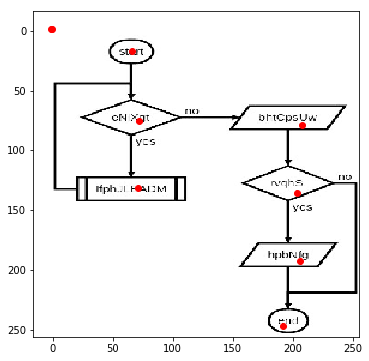

Actual :  ['if', 'ZCXDB', 'end', 'QVfwJ', 'while', 'vxuXT', 'end']
Predict:  ['<START>', 'if', 'statement', 'end', 'statement', 'while', 'statement', 'end', '<END>']
           0         1         2
0    <START>  0.126516  0.094888
1         if  0.376785  0.094914
2  statement  0.372576  0.393082
3        end -0.001580 -0.002257
4  statement  0.634532  0.393082
5      while  0.637704  0.646015
6  statement  0.634545  0.939686
7        end -0.001580 -0.002257
8      <END>  0.957137  0.646015
[[ 1.334558    0.92733115]
 [ 3.7347996   0.9190381 ]
 [ 3.5161839   4.222464  ]
 [-1.1507097  -1.1599772 ]
 [ 6.6799874   4.0579214 ]
 [ 6.458528    6.5337687 ]
 [ 6.4542174   9.629118  ]
 [-1.0774736  -1.0161214 ]
 [ 9.516355    6.417205  ]]
[[ 34.164684   23.739677 ]
 [ 95.61087    23.527376 ]
 [ 90.014305  108.095085 ]
 [ -1.1507097  -1.1599772]
 [171.00768   103.88279  ]
 [165.33832   167.26448  ]
 [165.22797   246.50542  ]
 [ -1.0774736  -1.0161214]
 [243.61868   164.28044  ]]


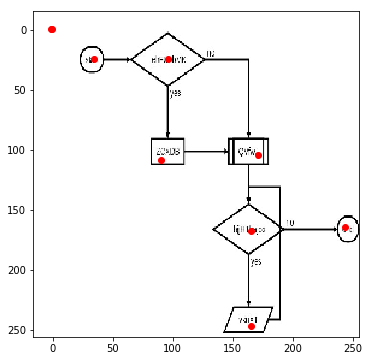

Actual :  ['if', 'WolhnSSYyh', 'elseif', 'NErnbVDh', 'wgpSAVsQk', 'end']
Predict:  ['<START>', 'if', 'statement', 'elseif', 'statement', 'statement', 'end', '<END>']
           0         1         2
0    <START>  0.193445  0.086347
1         if  0.205545  0.285834
2  statement  0.827746  0.285803
3     elseif  0.194091  0.536090
4  statement  0.193401  0.756673
5  statement  0.191492  0.956128
6        end -0.001880 -0.001616
7      <END>  0.578234  0.956128
[[ 2.0044632  0.7348789]
 [ 2.0137558  2.5036736]
 [ 8.020005   2.52851  ]
 [ 1.7307454  5.2256813]
 [ 2.1004326  7.3015747]
 [ 1.478716   9.435401 ]
 [-1.1871451 -1.33975  ]
 [ 5.397668   9.693761 ]]
[[ 51.31426    18.8129   ]
 [ 51.55215    64.09405  ]
 [205.31213    64.72986  ]
 [ 44.307083  133.77745  ]
 [ 53.771076  186.92032  ]
 [ 37.85513   241.54626  ]
 [ -1.1871451  -1.33975  ]
 [138.1803    248.16028  ]]
Actual :  ['AyPKv', 'wgAUiCrteCUv', 'while', 'HUtQt', 'end']
Predict:  ['<START>', 'statement', 'statement', 'while', '

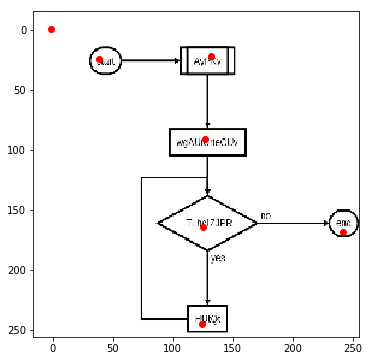

Actual :  ['PGxPpi', 'oCerbceDW', 'xTooWAbCh', 'while', 'agAZIHnniibX', 'end', 'qSNPWx']
Predict:  ['<START>', 'statement', 'statement', 'statement', 'while', 'statement', 'end', 'statement', '<END>']
           0         1         2
0    <START>  0.161913  0.072229
1  statement  0.446664  0.072229
2  statement  0.446652  0.241971
3  statement  0.446626  0.411712
4      while  0.454673  0.581473
5  statement  0.848429  0.581454
6        end -0.001623 -0.001393
7  statement  0.446652  0.792807
8      <END>  0.446690  0.962548
[[ 1.5018075   0.63622224]
 [ 4.651074    0.56163013]
 [ 4.4511566   2.715586  ]
 [ 4.4893193   4.5143995 ]
 [ 4.427173    6.4143596 ]
 [ 8.614058    6.3951383 ]
 [-1.0938413  -0.9090895 ]
 [ 4.5179915   8.576899  ]
 [ 5.240679    9.696756  ]]
[[ 38.44627    16.28729  ]
 [119.0675     14.377731 ]
 [113.94961    69.519005 ]
 [114.926575  115.56863  ]
 [113.33563   164.20761  ]
 [220.51988   163.71555  ]
 [ -1.0938413  -0.9090895]
 [115.66058   219.5686   ]
 [134.161

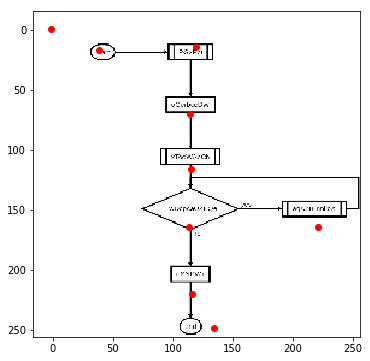

Actual :  ['mFrkFYjI', 'while', 'SWJcGvRPBnC', 'while', 'JsJFxBkmEc', 'end', 'end']
Predict:  ['<START>', 'statement', 'while', 'statement', 'while', 'statement', 'end', 'end', '<END>']
           0         1         2
0    <START>  0.111751  0.144738
1  statement  0.111723  0.492414
2      while  0.353699  0.492436
3  statement  0.603770  0.492414
4      while  0.864566  0.492470
5  statement  0.858393  0.921101
6        end -0.001166 -0.002899
7        end -0.001166 -0.002899
8      <END>  0.352178  0.886489
[[ 1.090111    1.4454105 ]
 [ 1.0680555   4.7247877 ]
 [ 3.2992475   4.60713   ]
 [ 6.1915846   5.0672693 ]
 [ 8.357271    5.185875  ]
 [ 8.573843    9.198687  ]
 [-1.1499258  -0.99637383]
 [-0.9140444  -0.87897354]
 [ 3.847799    9.0016    ]]
[[ 27.906843    37.00251   ]
 [ 27.342222   120.95457   ]
 [ 84.46074    117.94253   ]
 [158.50456    129.72209   ]
 [213.94615    132.7584    ]
 [219.49039    235.48637   ]
 [ -1.1499258   -0.99637383]
 [ -0.9140444   -0.87897354]
 [ 98.50

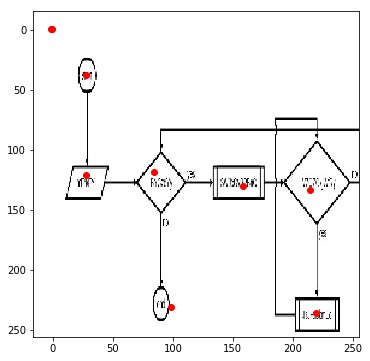

Actual :  ['while', 'mRAmFS', 'KLUTVR', 'end', 'while', 'CsXciof', 'end']
Predict:  ['<START>', 'while', 'statement', 'statement', 'end', 'while', 'statement', 'end', '<END>']
           0         1         2
0    <START>  0.105778  0.291585
1      while  0.299382  0.291671
2  statement  0.293305  0.890879
3  statement  0.520493  0.890879
4        end -0.001081 -0.004000
5      while  0.717391  0.291632
6  statement  0.712078  0.882419
7        end -0.001081 -0.004000
8      <END>  0.970928  0.291585
[[ 0.81748617  2.6355722 ]
 [ 2.6934228   2.8362195 ]
 [ 2.7344215   8.347842  ]
 [ 5.2603555   8.738402  ]
 [-0.8047968  -0.82424504]
 [ 7.4789267   3.026808  ]
 [ 7.0828547   8.648688  ]
 [-0.9461782  -0.82241935]
 [ 9.668769    3.2350872 ]]
[[ 20.927647    67.47065   ]
 [ 68.95162     72.60722   ]
 [ 70.00119    213.70476   ]
 [134.6651     223.70311   ]
 [ -0.8047968   -0.82424504]
 [191.46053     77.48629   ]
 [181.32109    221.40642   ]
 [ -0.9461782   -0.82241935]
 [247.5205      82

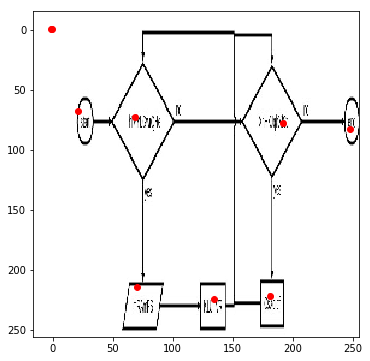

Actual :  ['if', 'uxkMRNj', 'end', 'YPqkTpTAJg']
Predict:  ['<START>', 'if', 'statement', 'end', 'statement', '<END>']
           0         1         2
0    <START>  0.241735  0.083962
1         if  0.725220  0.083994
2  statement  0.728330  0.381700
3        end -0.003236 -0.002703
4  statement  0.728305  0.654892
5      <END>  0.728406  0.928083
[[ 2.3007417   1.0099851 ]
 [ 7.371082    0.93145347]
 [ 7.104079    4.0113587 ]
 [-1.1506081  -1.0067828 ]
 [ 7.361029    6.609456  ]
 [ 7.1129527   9.394178  ]]
[[ 58.898987   25.85562  ]
 [188.69969    23.84521  ]
 [181.86443   102.69079  ]
 [ -1.1506081  -1.0067828]
 [188.44235   169.20207  ]
 [182.0916    240.49097  ]]


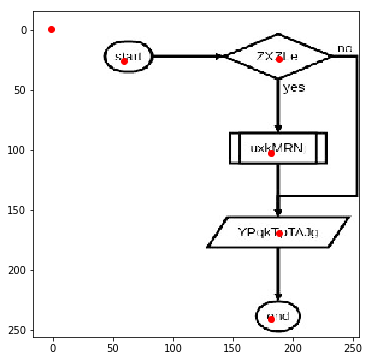

Actual :  ['while', 'dXdLWr', 'iwBdroFIJ', 'lqdFKxptd', 'end']
Predict:  ['<START>', 'while', 'statement', 'statement', 'statement', 'end', '<END>']
           0         1         2
0    <START>  0.118581  0.182084
1      while  0.391172  0.182084
2  statement  0.393472  0.560082
3  statement  0.712042  0.560082
4  statement  0.712042  0.907153
5        end -0.002066 -0.003436
6      <END>  0.945136  0.182084
[[ 1.1051036  1.7411668]
 [ 3.5600476  1.5882721]
 [ 3.9692357  5.415221 ]
 [ 7.4148517  6.274545 ]
 [ 7.1781135  9.261367 ]
 [-0.9441265 -1.0389225]
 [ 9.801247   1.8748538]]
[[ 28.290653   44.57387  ]
 [ 91.13722    40.659767 ]
 [101.612434  138.62967  ]
 [189.8202    160.62836  ]
 [183.7597    237.09099  ]
 [ -0.9441265  -1.0389225]
 [250.91191    47.996258 ]]


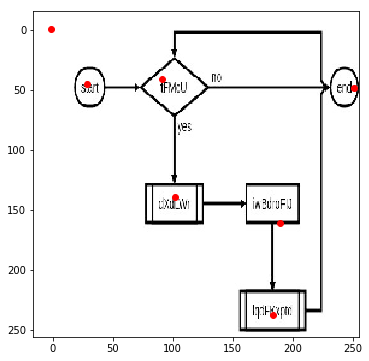

Actual :  ['while', 'BkqFqNTCOy', 'end', 'ZsGecPdyRB', 'while', 'ZckFN', 'end']
Predict:  ['<START>', 'while', 'statement', 'end', 'statement', 'while', 'statement', 'end', '<END>']
           0         1         2
0    <START>  0.131008  0.123492
1      while  0.366482  0.123519
2  statement  0.873441  0.123492
3        end -0.001350 -0.002016
4  statement  0.364105  0.401341
5      while  0.371548  0.644376
6  statement  0.364137  0.944965
7        end -0.001350 -0.002016
8      <END>  0.690993  0.644376
[[ 1.1469222  1.293712 ]
 [ 3.4581177  1.2886363]
 [ 8.51881    1.4549637]
 [-1.0038865 -1.1063371]
 [ 3.5745213  4.2119675]
 [ 3.9661725  6.6075654]
 [ 3.7898846  9.595685 ]
 [-1.0666852 -1.0213993]
 [ 7.04212    6.5161786]]
[[ 29.36121    33.11903  ]
 [ 88.52782    32.98909  ]
 [218.08154    37.24707  ]
 [ -1.0038865  -1.1063371]
 [ 91.507744  107.82637  ]
 [101.53402   169.15367  ]
 [ 97.02105   245.64954  ]
 [ -1.0666852  -1.0213993]
 [180.27827   166.81418  ]]


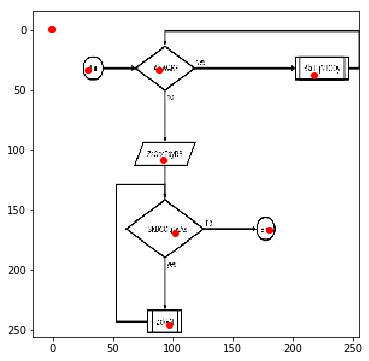

Actual :  ['if', 'FmNxTLAIszCO', 'end', 'TXrJO', 'SuIJxTgKIuR', 'tGMJEnWRp']
Predict:  ['<START>', 'if', 'statement', 'end', 'statement', 'statement', 'statement', '<END>']
           0         1         2
0    <START>  0.176799  0.083381
1         if  0.185512  0.289402
2  statement  0.176723  0.540235
3        end -0.001938 -0.001751
4  statement  0.176799  0.746225
5  statement  0.532389  0.746225
6  statement  0.532404  0.952215
7      <END>  0.947539  0.952215
[[ 1.7827309  0.8092905]
 [ 1.7512548  2.7197685]
 [ 1.6382678  5.5128965]
 [-1.1991564 -1.2320828]
 [ 2.1420472  6.601296 ]
 [ 4.2177052  8.338293 ]
 [ 6.1003213  9.185365 ]
 [ 8.9546     9.653    ]]
[[ 45.637913   20.717838 ]
 [ 44.832123   69.626076 ]
 [ 41.939655  141.13016  ]
 [ -1.1991564  -1.2320828]
 [ 54.836407  168.99318  ]
 [107.97326   213.46031  ]
 [156.16823   235.14534  ]
 [229.23778   247.1168   ]]


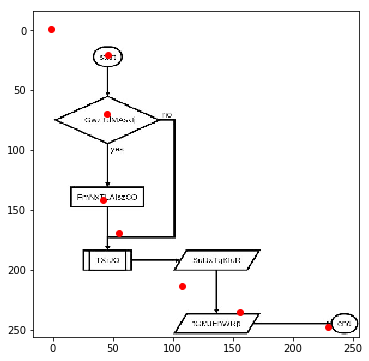

Actual :  ['if', 'drhPYlNo', 'elseif', 'divDrOxUhQsa', 'end']
Predict:  ['<START>', 'if', 'statement', 'elseif', 'statement', 'end', '<END>']
           0         1         2
0    <START>  0.200510  0.097841
1         if  0.206584  0.362016
2  statement  0.200470  0.671757
3     elseif  0.722294  0.362021
4  statement  0.724263  0.648891
5        end -0.002558 -0.002375
6      <END>  0.200530  0.935905
[[ 2.3179176  1.0038881]
 [ 2.2453866  3.4892828]
 [ 2.310256   6.729015 ]
 [ 7.3521914  3.4622114]
 [ 7.43581    6.7701616]
 [-0.7042849 -0.8232644]
 [ 2.2022884  9.452954 ]]
[[ 59.33869    25.699537 ]
 [ 57.4819     89.325645 ]
 [ 59.142555  172.26279  ]
 [188.21611    88.632614 ]
 [190.35674   173.31615  ]
 [ -0.7042849  -0.8232644]
 [ 56.378582  241.99564  ]]


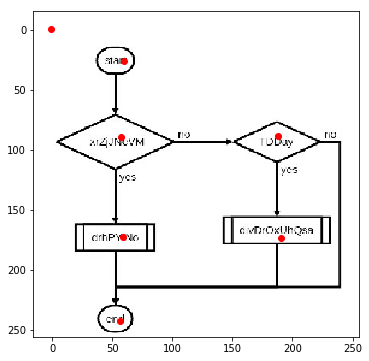

Actual :  ['if', 'HShzrMbNF', 'end', 'while', 'dGEbHo', 'end', 'while', 'wEhLyYFm', 'end']
Predict:  ['<START>', 'if', 'statement', 'end', 'while', 'statement', 'end', 'while', 'statement', 'end', '<END>']
            0         1         2
0     <START>  0.115093  0.100335
1          if  0.323273  0.100368
2   statement  0.899700  0.100335
3         end -0.001138 -0.001908
4       while  0.319904  0.392691
5   statement  0.722868  0.392665
6         end -0.001138 -0.001908
7       while  0.321108  0.667888
8   statement  0.315100  0.949160
9         end -0.001138 -0.001908
10      <END>  0.587934  0.667888
[[ 1.0524344   0.75924075]
 [ 3.2016726   0.7590872 ]
 [ 8.596452    0.9256327 ]
 [-1.0761237  -1.1082671 ]
 [ 3.481895    3.99085   ]
 [ 7.3143463   4.0129623 ]
 [-0.6434566  -0.74115795]
 [ 3.3279245   6.581955  ]
 [ 3.2245793   9.33163   ]
 [-1.0464419  -0.92503804]
 [ 5.5297694   6.930224  ]]
[[ 26.942322    19.436563  ]
 [ 81.96282     19.432632  ]
 [220.06917     23.696198  ]
 

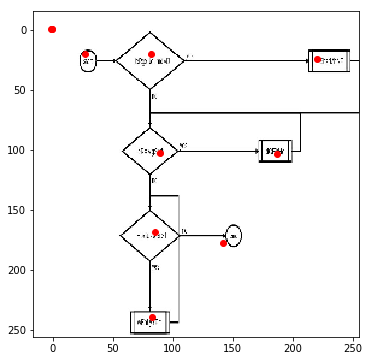

Actual :  ['if', 'bKsYvXIvFAE', 'while', 'YFVvpIW', 'end', 'end']
Predict:  ['<START>', 'if', 'statement', 'while', 'statement', 'end', 'end', '<END>']
           0         1         2
0    <START>  0.160450  0.098019
1         if  0.471425  0.098019
2  statement  0.464982  0.400790
3      while  0.466492  0.654443
4  statement  0.847734  0.654395
5        end -0.001905 -0.002222
6        end -0.001905 -0.002222
7      <END>  0.465056  0.939862
[[ 1.579662    1.0159335 ]
 [ 4.8532915   0.98571897]
 [ 4.450213    4.103073  ]
 [ 4.4995356   6.80546   ]
 [ 8.69466     6.9803033 ]
 [-1.0646194  -1.094758  ]
 [-0.93592894 -0.9761935 ]
 [ 4.6849155   9.564395  ]]
[[ 40.439346    26.007898  ]
 [124.24426     25.234406  ]
 [113.92545    105.03867   ]
 [115.18811    174.21977   ]
 [222.5833     178.69577   ]
 [ -1.0646194   -1.094758  ]
 [ -0.93592894  -0.9761935 ]
 [119.93384    244.84851   ]]


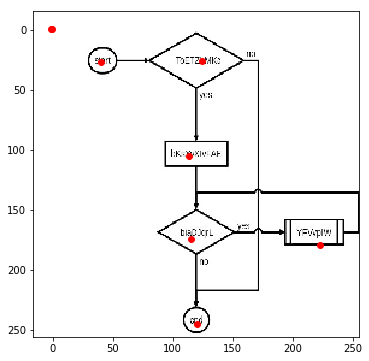

Actual :  ['while', 'yStvkvLSpIG', 'if', 'lYmUAqqcmBfU', 'end', 'end']
Predict:  ['<START>', 'while', 'statement', 'if', 'statement', 'end', 'end', '<END>']
           0         1         2
0    <START>  0.181429  0.133515
1      while  0.524317  0.133534
2  statement  0.525206  0.410377
3         if  0.521710  0.661001
4  statement  0.525172  0.933576
5        end -0.002146 -0.002439
6        end -0.002146 -0.002439
7      <END>  0.941741  0.133515
[[ 1.8389171   1.2710502 ]
 [ 5.1446996   1.2814727 ]
 [ 5.017534    4.232889  ]
 [ 4.9638824   6.986024  ]
 [ 5.0117464   9.613806  ]
 [-1.1011716  -1.1361837 ]
 [-0.9075668  -0.94062144]
 [ 9.414957    1.5100534 ]]
[[ 47.07628     32.538887  ]
 [131.70432     32.805702  ]
 [128.44887    108.36196   ]
 [127.07539    178.84221   ]
 [128.3007     246.11343   ]
 [ -1.1011716   -1.1361837 ]
 [ -0.9075668   -0.94062144]
 [241.0229      38.657368  ]]


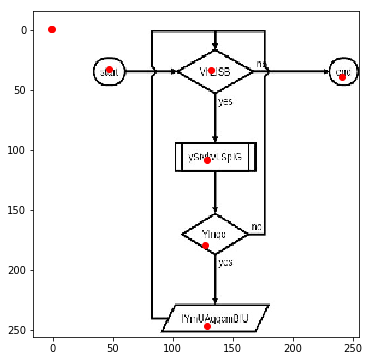

Actual :  ['hrppYUqbtl', 'if', 'OgfKufPwOcHS', 'end']
Predict:  ['<START>', 'statement', 'if', 'statement', 'end', '<END>']
           0         1         2
0    <START>  0.160028  0.130469
1  statement  0.463846  0.130469
2         if  0.809926  0.130514
3  statement  0.808285  0.549922
4        end -0.001901 -0.003300
5      <END>  0.808374  0.911460
[[ 1.55307    1.2061493]
 [ 4.470837   1.2038766]
 [ 8.063878   1.5129917]
 [ 7.7052436  5.670309 ]
 [-1.0316541 -0.9794546]
 [ 7.8391633  9.322784 ]]
[[ 39.75859    30.877424 ]
 [114.45343    30.819242 ]
 [206.43529    38.732586 ]
 [197.25424   145.15991  ]
 [ -1.0316541  -0.9794546]
 [200.68259   238.66328  ]]


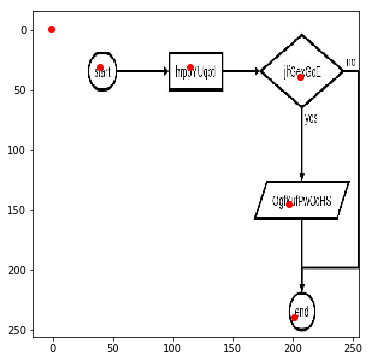

Actual :  ['OuMXYxRDOUj', 'if', 'CYTLrzxwQdqL', 'end', 'while', 'vyeTVtPT', 'end']
Predict:  ['<START>', 'statement', 'if', 'statement', 'end', 'while', 'statement', 'end', '<END>']
           0         1         2
0    <START>  0.156749  0.084516
1  statement  0.156676  0.282324
2         if  0.529138  0.282356
3  statement  0.519656  0.529074
4        end -0.001560 -0.001618
5      while  0.523428  0.726917
6  statement  0.873709  0.726882
7        end -0.001560 -0.001618
8      <END>  0.519729  0.955779
[[ 1.4451734   0.76655275]
 [ 1.5225221   2.722227  ]
 [ 5.019609    2.9048328 ]
 [ 4.8650026   5.325805  ]
 [-1.1973056  -1.1277456 ]
 [ 4.9195523   7.1770535 ]
 [ 8.733961    7.233303  ]
 [-1.0092849  -1.034111  ]
 [ 4.8952937   9.625148  ]]
[[ 36.99644    19.62375  ]
 [ 38.976566   69.68902  ]
 [128.502      74.36372  ]
 [124.54407   136.34062  ]
 [ -1.1973056  -1.1277456]
 [125.940544  183.73257  ]
 [223.5894    185.17256  ]
 [ -1.0092849  -1.034111 ]
 [125.31952   246.4038   ]]


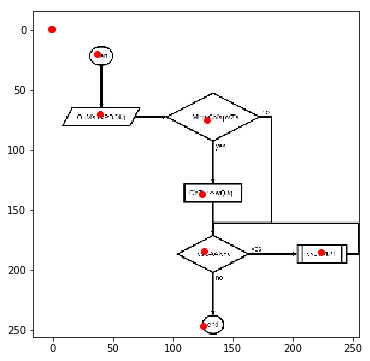

Actual :  ['GKzKP', 'if', 'fHZqLbRL', 'elseif', 'iDtTbfgix', 'while', 'UrVFiMxLE', 'end', 'end']
Predict:  ['<START>', 'statement', 'if', 'statement', 'elseif', 'statement', 'while', 'statement', 'end', 'end', '<END>']
            0         1         2
0     <START>  0.106801  0.078144
1   statement  0.106791  0.286908
2          if  0.110284  0.495686
3   statement  0.106780  0.741558
4      elseif  0.382427  0.495671
5   statement  0.627958  0.495671
6       while  0.630254  0.704460
7   statement  0.898554  0.704435
8         end -0.001339 -0.001866
9         end -0.001339 -0.001866
10      <END>  0.106812  0.950322
[[ 1.0223877   0.7324089 ]
 [ 0.9731964   2.7870438 ]
 [ 0.9390322   4.936192  ]
 [ 1.3706884   7.5336447 ]
 [ 3.9048305   4.8834004 ]
 [ 6.286638    5.529822  ]
 [ 7.3486066   6.437915  ]
 [ 9.134436    7.0361767 ]
 [-1.096355   -1.1002543 ]
 [-0.6735809  -0.92043227]
 [ 2.0371177   9.041691  ]]
[[ 26.173126    18.749668  ]
 [ 24.913828    71.34832   ]
 [ 24.039225   12

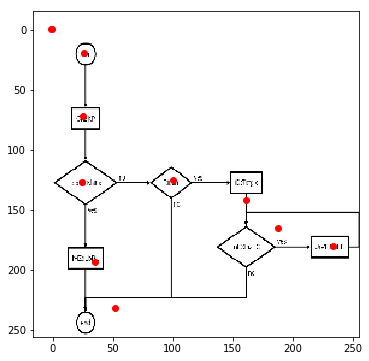

Actual :  ['pefkerQc', 'while', 'WaiwAgIQpBJX', 'end']
Predict:  ['<START>', 'statement', 'while', 'statement', 'end', '<END>']
           0         1         2
0    <START>  0.179175  0.123043
1  statement  0.519977  0.123043
2      while  0.520737  0.491783
3  statement  0.519944  0.906362
4        end -0.002137 -0.003509
5      <END>  0.943151  0.491749
[[ 1.6527358  1.2784755]
 [ 4.9607096  1.2112639]
 [ 4.982575   4.9401226]
 [ 5.1064763  9.277273 ]
 [-1.0626985 -1.0591729]
 [ 9.37423    5.0885715]]
[[ 42.31004    32.728973 ]
 [126.99416    31.008356 ]
 [127.55392   126.46714  ]
 [130.7258    237.4982   ]
 [ -1.0626985  -1.0591729]
 [239.9803    130.26744  ]]


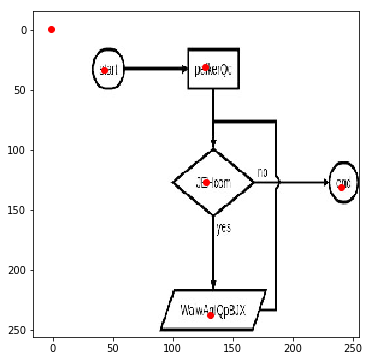

Actual :  ['XXdtqehKKeh', 'opAoiuhAFD', 'while', 'JyzLigCaXhaH', 'end']
Predict:  ['<START>', 'statement', 'statement', 'while', 'statement', 'end', '<END>']
           0         1         2
0    <START>  0.084169  0.278866
1  statement  0.258934  0.278866
2  statement  0.470039  0.278866
3      while  0.674487  0.278866
4  statement  0.885040  0.278866
5        end -0.001198 -0.005263
6      <END>  0.676054  0.857811
[[ 0.7858521  2.654207 ]
 [ 2.4198587  2.629037 ]
 [ 4.3734345  2.6988726]
 [ 6.47511    3.1037881]
 [ 9.129229   2.8063402]
 [-1.1380483 -1.0016308]
 [ 6.606776   8.758079 ]]
[[ 20.117813   67.9477   ]
 [ 61.948383   67.303345 ]
 [111.95992    69.09114  ]
 [165.76282    79.45698  ]
 [233.70825    71.84231  ]
 [ -1.1380483  -1.0016308]
 [169.13347   224.20682  ]]


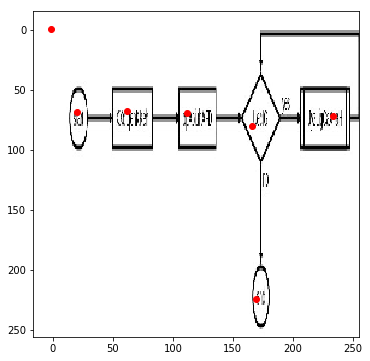

In [16]:
def analyze():
    files = glob.glob("./data/*")
    count = 0
    
    for idx in x_test_idx:
        count += 1
        if count % 5 == 0:
            picture_files = list(filter(re.compile(".\/data\/sample-" + str(idx) + "-\d+.jpg").search, files))
            lang_file = list(filter(re.compile(".\/data\/sample-" + str(idx) + "-lang.txt").search, files))

            image, img_width, img_height = read_image(picture_files[0])
            match = re.match( r'.+sample-(\d+)-(\d+).jpg', picture_files[0])   
            pic_id = match.group(2)

            with open(lang_file[0], 'r') as file:
                lang = [l.strip().split(" ")[0] for l in file.read().split("\n") if len(l)]
                lang = list(map(lambda x: "statement" if x.startswith("statement") else x, lang))

            plt.figure(figsize=(6,6))
            plt.imshow(image.reshape((IMAGE_SIZE, IMAGE_SIZE)), cmap="Greys")
            
            print("Actual : ", lang)
            
            tokens = np.zeros((BATCH_SIZE, PADDING_SIZE))
            images = np.zeros((BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 1))
            results = []
            
            token = [''] * (PADDING_SIZE + 1)
            
            for i in range(BATCH_SIZE):
                images[i] = image
            
            position = []
            
            for i in range(20):
                token = token[1:]
                
                tokens[BATCH_SIZE - 1] = convert_to_feature_list(token)
                
                pos, predict = model.predict([tokens, images])
                predict_token = ALL_WORD[np.argmax(predict[BATCH_SIZE - 1])]
                results.append(predict_token)
                
                token += [predict_token]
                position += [pos[BATCH_SIZE - 1]]
                
                if predict_token == "<END>":
                    break
            
            print("Predict: ", results)
            
            pos_true = pd.read_csv("./data/sample-{}-{}-block-pos.csv".format(idx, pic_id), header=None)
            pos_true.loc[pos_true[0] == "else", [1,2]] = -1
            pos_true[[1,2]] = pos_true[[1,2]].astype(float)
            pos_true[1] /= img_width
            pos_true[2] /= img_height
            
            print(pos_true)
            
            position = np.array(position)
            print(position)
            position[position[:,0] > 0,0] *= IMAGE_SIZE / 10
            position[position[:,1] > 0,1] *= IMAGE_SIZE / 10
            print(position)
            plt.scatter(position[:,0], position[:,1], c='r')
            plt.show()
        
        if count > 100:
            break

analyze()